In [1]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.cluster import KMeans



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss



import warnings
warnings.filterwarnings('ignore')

In [3]:
os.listdir('../input/lish-moa')

['test_features.csv',
 'sample_submission.csv',
 'train_drug.csv',
 'train_features.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv']

In [4]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [5]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [6]:
#RankGauss

for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=1, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [7]:
def seed_everything(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=1)

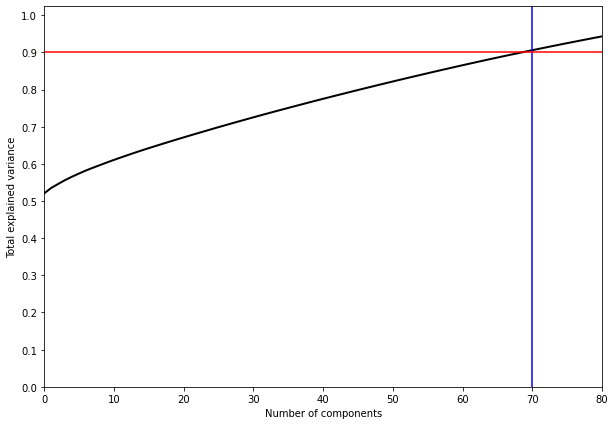

In [8]:
pca = PCA(random_state=1).fit(train_features[CELLS])

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 80)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(70, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [9]:
# GENES
n_comp = 480  #<--Update
pca_g = PCA(n_components=n_comp, random_state=1)
train2 = pca_g.fit_transform(train_features[GENES])
test2 =  pca_g.transform(test_features[GENES])

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [10]:
#CELLS
n_comp = 69  #<--Update
pca_c = PCA(n_components=n_comp, random_state=1)
train2 = pca_c.fit_transform(train_features[CELLS])
test2 = pca_c.transform(test_features[CELLS])

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [11]:
train_features.shape

(23814, 1425)

In [12]:
var_thresh = VarianceThreshold(0.8)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features.shape

(23814, 1039)

In [13]:
def fe_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 123):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features ,test_features=fe_cluster(train_features,test_features)

In [14]:
def process_data(df):
    df['time_dose'] = df['cp_time'].astype(str)+df['cp_dose']
    
    df = pd.get_dummies(df, columns=['time_dose'])
    
    
    features_g = list(df.columns[4:776])
    features_c = list(df.columns[776:876])
    
    df['g_sum'] = df[features_g].sum(axis = 1)
    df['g_mean'] = df[features_g].mean(axis = 1)
    df['g_std'] = df[features_g].std(axis = 1)
    df['g_kurt'] = df[features_g].kurtosis(axis = 1)
    df['g_skew'] = df[features_g].skew(axis = 1)
    df['c_sum'] = df[features_c].sum(axis = 1)
    df['c_mean'] = df[features_c].mean(axis = 1)
    df['c_std'] = df[features_c].std(axis = 1)
    df['c_kurt'] = df[features_c].kurtosis(axis = 1)
    df['c_skew'] = df[features_c].skew(axis = 1)
    df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
    df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
    df['gc_std'] = df[features_g + features_c].std(axis = 1)
    df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
    df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
    
    features_c = list(df.columns[776:876])
    for feature in features_c:
        df[f'{feature}_squared'] = df[feature] ** 2
    
    return df

train_features = process_data(train_features)
test_features = process_data(test_features)

In [15]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [16]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [17]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

In [18]:
SEED = 42
FOLDS = 11

# LOAD FILES
scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
targets = scored.columns[1:]
scored = scored.merge(drug, on='sig_id', how='left') 

# LOCATE DRUGS
vc = scored.drug_id.value_counts()
vc1 = vc.loc[(vc==6)|(vc==12)|(vc==18)].index.sort_values()
vc2 = vc.loc[(vc!=6)&(vc!=12)&(vc!=18)].index.sort_values()

# STRATIFY DRUGS 18X OR LESS
dct1 = {}; dct2 = {}
skf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True, 
          random_state=SEED)
tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
    dd = {k:fold for k in tmp.index[idxV].values}
    dct1.update(dd)

# STRATIFY DRUGS MORE THAN 18X
skf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True, 
          random_state=SEED)
tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
    dd = {k:fold for k in tmp.sig_id[idxV].values}
    dct2.update(dd)

# ASSIGN FOLDS
scored['fold'] = scored.drug_id.map(dct1)
scored.loc[scored.fold.isna(),'fold'] =\
    scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
scored.fold = scored.fold.astype('int8')

In [19]:
folds = pd.merge(train,scored[['sig_id','fold']],on='sig_id',how='left')

In [20]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1405)
(21948, 1406)
(3624, 1199)
(21948, 207)
(3982, 207)


# Dataset Classes

In [21]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

In [22]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds
   
    

In [23]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [24]:
class Model(nn.Module):      # <-- Update
    def __init__(self, num_features, num_targets, hidden_size_medium, hidden_size_final):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size_medium))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size_medium)
        self.dropout2 = nn.Dropout(0.3)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size_medium, hidden_size_final))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size_final)
        self.dropout3 = nn.Dropout(0.3)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size_final, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [25]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [26]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['fold','sig_id']]
len(feature_cols)

1201

In [27]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 6e-4
WEIGHT_DECAY = 1e-5
NFOLDS = 11
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size_medium=2048
hidden_size_final=1024

In [28]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['fold'] != fold].index
    val_idx = train[train['fold'] == fold].index
    
    train_df = train[train['fold'] != fold].reset_index(drop=True)
    valid_df = train[train['fold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size_medium=hidden_size_medium,
        hidden_size_final = hidden_size_final
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    print(f"FOLD: {fold}")
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"EPOCH: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size_medium=hidden_size_medium,
        hidden_size_final = hidden_size_final

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions


In [29]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [30]:
# Averaging on multiple SEEDS

SEED = [561, 42, 256, 1881, 1903, 2020, 567]
oof_model1 = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    print(f"SEED: {seed}")
    oof_, predictions_ = run_k_fold(FOLDS, seed)
    oof_model1 += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof_model1
test[target_cols] = predictions


SEED: 561
FOLD: 0
EPOCH: 0, train_loss: 0.6570158849159876, valid_loss: 0.253533985465765
EPOCH: 1, train_loss: 0.056413830210192084, valid_loss: 0.02108090603724122
EPOCH: 2, train_loss: 0.02279845293229207, valid_loss: 0.01913605281151831
EPOCH: 3, train_loss: 0.02144935462050713, valid_loss: 0.019143662648275495
EPOCH: 4, train_loss: 0.020649441135808442, valid_loss: 0.017951265908777714
EPOCH: 5, train_loss: 0.02020280340161079, valid_loss: 0.01926630549132824
EPOCH: 6, train_loss: 0.020549086997142203, valid_loss: 0.017728911014273763
EPOCH: 7, train_loss: 0.020022131884709384, valid_loss: 0.01748790906276554
EPOCH: 8, train_loss: 0.019876352917307463, valid_loss: 0.01768555771559477
EPOCH: 9, train_loss: 0.019783958338965207, valid_loss: 0.01756078947801143
EPOCH: 10, train_loss: 0.019747858055126973, valid_loss: 0.017650770489126444
EPOCH: 11, train_loss: 0.0196923827036069, valid_loss: 0.01725150435231626
EPOCH: 12, train_loss: 0.019598482343821954, valid_loss: 0.01743618515320

In [31]:
# save oof 
os.makedirs('MODELS_OOF/', exist_ok=True)

#will store our models here
np.save('MODELS_OOF/oof_model1.npy', oof_model1)

In [32]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)

CV log_loss:  0.015454305745102563


In [33]:
sub_1 = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub_1.to_csv('submission.csv', index=False)

In [34]:
sub_1.shape

(3982, 207)

In [35]:
BLEND = sub_1.copy()

In [36]:
TARGET_COL = ['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor', 'acat_inhibitor', 'acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor', 'adenosine_receptor_agonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist', 'adrenergic_receptor_antagonist', 'akt_inhibitor', 'aldehyde_dehydrogenase_inhibitor', 'alk_inhibitor', 'ampk_activator', 'analgesic', 'androgen_receptor_agonist', 'androgen_receptor_antagonist', 'anesthetic_-_local', 'angiogenesis_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'antibiotic', 'anticonvulsant', 'antifungal', 'antihistamine', 'antimalarial', 'antioxidant', 'antiprotozoal', 'antiviral', 'apoptosis_stimulant', 'aromatase_inhibitor', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atpase_inhibitor', 'atr_kinase_inhibitor', 'aurora_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_30s_ribosomal_subunit_inhibitor', 'bacterial_50s_ribosomal_subunit_inhibitor', 'bacterial_antifolate', 'bacterial_cell_wall_synthesis_inhibitor', 'bacterial_dna_gyrase_inhibitor', 'bacterial_dna_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcl_inhibitor', 'bcr-abl_inhibitor', 'benzodiazepine_receptor_agonist', 'beta_amyloid_inhibitor', 'bromodomain_inhibitor', 'btk_inhibitor', 'calcineurin_inhibitor', 'calcium_channel_blocker', 'cannabinoid_receptor_agonist', 'cannabinoid_receptor_antagonist', 'carbonic_anhydrase_inhibitor', 'casein_kinase_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cc_chemokine_receptor_antagonist', 'cck_receptor_antagonist', 'cdk_inhibitor', 'chelating_agent', 'chk_inhibitor', 'chloride_channel_blocker', 'cholesterol_inhibitor', 'cholinergic_receptor_antagonist', 'coagulation_factor_inhibitor', 'corticosteroid_agonist', 'cyclooxygenase_inhibitor', 'cytochrome_p450_inhibitor', 'dihydrofolate_reductase_inhibitor', 'dipeptidyl_peptidase_inhibitor', 'diuretic', 'dna_alkylating_agent', 'dna_inhibitor', 'dopamine_receptor_agonist', 'dopamine_receptor_antagonist', 'egfr_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'estrogen_receptor_agonist', 'estrogen_receptor_antagonist', 'faah_inhibitor', 'farnesyltransferase_inhibitor', 'fatty_acid_receptor_agonist', 'fgfr_inhibitor', 'flt3_inhibitor', 'focal_adhesion_kinase_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'gamma_secretase_inhibitor', 'glucocorticoid_receptor_agonist', 'glutamate_inhibitor', 'glutamate_receptor_agonist', 'glutamate_receptor_antagonist', 'gonadotropin_receptor_agonist', 'gsk_inhibitor', 'hcv_inhibitor', 'hdac_inhibitor', 'histamine_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'histone_lysine_methyltransferase_inhibitor', 'hiv_inhibitor', 'hmgcr_inhibitor', 'hsp_inhibitor', 'igf-1_inhibitor', 'ikk_inhibitor', 'imidazoline_receptor_agonist', 'immunosuppressant', 'insulin_secretagogue', 'insulin_sensitizer', 'integrin_inhibitor', 'jak_inhibitor', 'kit_inhibitor', 'laxative', 'leukotriene_inhibitor', 'leukotriene_receptor_antagonist', 'lipase_inhibitor', 'lipoxygenase_inhibitor', 'lxr_agonist', 'mdm_inhibitor', 'mek_inhibitor', 'membrane_integrity_inhibitor', 'mineralocorticoid_receptor_antagonist', 'monoacylglycerol_lipase_inhibitor', 'monoamine_oxidase_inhibitor', 'monopolar_spindle_1_kinase_inhibitor', 'mtor_inhibitor', 'mucolytic_agent', 'neuropeptide_receptor_antagonist', 'nfkb_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_donor', 'nitric_oxide_production_inhibitor', 'nitric_oxide_synthase_inhibitor', 'norepinephrine_reuptake_inhibitor', 'nrf2_activator', 'opioid_receptor_agonist', 'opioid_receptor_antagonist', 'orexin_receptor_antagonist', 'p38_mapk_inhibitor', 'p-glycoprotein_inhibitor', 'parp_inhibitor', 'pdgfr_inhibitor', 'pdk_inhibitor', 'phosphodiesterase_inhibitor', 'phospholipase_inhibitor', 'pi3k_inhibitor', 'pkc_inhibitor', 'potassium_channel_activator', 'potassium_channel_antagonist', 'ppar_receptor_agonist', 'ppar_receptor_antagonist', 'progesterone_receptor_agonist', 'progesterone_receptor_antagonist', 'prostaglandin_inhibitor', 'prostanoid_receptor_antagonist', 'proteasome_inhibitor', 'protein_kinase_inhibitor', 'protein_phosphatase_inhibitor', 'protein_synthesis_inhibitor', 'protein_tyrosine_kinase_inhibitor', 'radiopaque_medium', 'raf_inhibitor', 'ras_gtpase_inhibitor', 'retinoid_receptor_agonist', 'retinoid_receptor_antagonist', 'rho_associated_kinase_inhibitor', 'ribonucleoside_reductase_inhibitor', 'rna_polymerase_inhibitor', 'serotonin_receptor_agonist', 'serotonin_receptor_antagonist', 'serotonin_reuptake_inhibitor', 'sigma_receptor_agonist', 'sigma_receptor_antagonist', 'smoothened_receptor_antagonist', 'sodium_channel_inhibitor', 'sphingosine_receptor_agonist', 'src_inhibitor', 'steroid', 'syk_inhibitor', 'tachykinin_antagonist', 'tgf-beta_receptor_inhibitor', 'thrombin_inhibitor', 'thymidylate_synthase_inhibitor', 'tlr_agonist', 'tlr_antagonist', 'tnf_inhibitor', 'topoisomerase_inhibitor', 'transient_receptor_potential_channel_antagonist', 'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist', 'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor', 'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b', 'vitamin_d_receptor_agonist', 'wnt_inhibitor']
NUM_TARGET = len(TARGET_COL)

df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")

public_id = list(df['sig_id'].values)

df_test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
test_id = list(df_test['sig_id'].values)

private_id = list(set(test_id)-set(public_id))

df_submit = pd.DataFrame(index = public_id+private_id, columns=TARGET_COL)
df_submit.index.name = 'sig_id'
df_submit[:] = 0
df_predict = BLEND.copy()
df_submit.loc[df_predict.sig_id,:] = df_predict[TARGET_COL].values
df_submit.loc[df_test[df_test.cp_type=='ctl_vehicle'].sig_id]= 0
df_submit.to_csv('submission.csv',index=True)